In [66]:
import numpy as np
import matplotlib.pyplot as plt

In [67]:
# Valeurs physiques
gamma = 72e-3; # Tension superficielle eau-air (en N/m)
theta_hydrophobe = 120; # Angle de contact eau-PDMS (en degrés) pré-plasmatisation
theta_hydrophile = 60; # Angle de contact eau-PDMS (en degrés) post-plasmatisation
rho = 1e3; # Masse volumique de l'eau (en kg/m^3)
eta = 1e-3; # Viscosité dynamique de l'eau (en Pa.s)
g = 9.81; # Accélération gravitationnelle (en m/s^2)

# Dimensions géométriques 
h_puce = 2.75e-3; # Épaisseur de la puce (en m)

d_inlet = 2.9e-3; # Diamètre interne de l'inlet (en m)
d_raman = 2e-3; # Diamètre interne du trou Raman (en m)
d_outlet = 1.5e-3 # Diamètre interne de l'outlet (en m)
d_bille = 0.35e-3; # Diamètre des billes (en m)

L_puits = 700e-6 # Longueur du puits (en m)
W_puits = 700e-6 # Largeur du puits (en m)
h_puits = 630e-6 # Hauteur du puits (en m)

W_canal = 700e-6 # Largeur du canal (en m)
h_canal = 700e-6 # Hauteur du canal (en m)

dist_x = 3e-3 # Longueur en x du serpentin (en m)
dist_y = 6e-3 # Longueur en y du serpentin (en m)

In [68]:
# Calculs associés
dist_inout = 2* dist_x + 2.5*dist_y + (2*np.pi*W_canal)
dist_puits = dist_x + dist_y + 0.5*(2*np.pi*W_canal)
dist_tot = 2*(dist_inout + dist_puits)
print(f"\nDistance entrée-puits et sortie-puits : {dist_inout*1000:.2f} mm")
print(f"Distance entre puits : {dist_puits*1000:.2f} mm")
print(f"Longueur totale du canal : {dist_tot*1000:.2f} mm")

r_inlet = d_inlet / 2
r_raman = d_raman / 2
r_outlet = d_outlet / 2

A_inlet = np.pi * r_inlet**2
A_raman = np.pi * r_raman**2
A_outlet = np.pi * r_outlet**2

# Caclul du volume total
V_puits = L_puits * W_puits * h_puits
V_raman = A_raman * h_puce
V_inlet = A_inlet * h_canal
V_outlet = A_outlet * h_canal
print(f"\nVolume pour un puits : {V_puits*1e9:.2f} uL")
print(f"Volume pour un accès raman : {V_raman*1e9:.2f} uL")
print(f"Volume de l'entrée : {V_inlet*1e9:.2f} uL")
print(f"Volume de sortie : {V_outlet*1e9:.2f} uL")

V_canal = W_canal * h_canal * (dist_tot - r_inlet - r_outlet)

V_tot = 3 * (V_puits + V_raman) + V_inlet + V_outlet + V_canal
print(f"\nVolume total : {V_tot*1e9:.2f} uL")
print(f"Première approximation de V_max : {V_tot*1.2*1e9:.2f} uL")

# Définition des distance entre les sections ouvertes du système
L1 = dist_inout;
L2 = dist_puits;
L3 = dist_puits;
L4 = dist_inout;


Distance entrée-puits et sortie-puits : 25.40 mm
Distance entre puits : 11.20 mm
Longueur totale du canal : 73.19 mm

Volume pour un puits : 0.31 uL
Volume pour un accès raman : 8.64 uL
Volume de l'entrée : 4.62 uL
Volume de sortie : 1.24 uL

Volume total : 67.49 uL
Première approximation de V_max : 80.99 uL


In [69]:
Vmax = 8.64e-9 # Volume maximal toléré par chaque trou Raman (en m^3)

In [70]:
def calc_R_rect(L, w, h, eta):
    R_rect = (12 * eta * L) / (h**3 * w)
    somme = 1
    for n_i in range(1, 10, 2):
        terme_somme = (192 * h) / (np.pi**5 * n_i**5 * w) * np.tanh(n_i * np.pi * w / (2 * h))
        somme -= terme_somme
    return R_rect / somme

def compute_volumes(L1, L2, L4, V0, t_final=10.0):
    """Renvoie les volumes écoulés dans chaque trou Raman pour un volume injecté V0."""
    A0 = np.pi * (2.9e-3 / 2)**2
    A = np.pi * (1e-3)**2

    C0 = A0 / (rho * g)
    C1 = C2 = C3 = A / (rho * g)

    R1 = calc_R_rect(L1, W_canal, h_canal, eta)
    R2 = calc_R_rect(L2, W_canal, h_canal, eta)
    R3 = R2
    R4 = calc_R_rect(L4, W_canal, h_canal, eta)

    M = -np.diag([-C0, C1, C2, C3])
    g1, g2, g3, g4 = 1/R1, 1/R2, 1/R3, 1/R4

    R_mat = np.array([
        [ g1,       -g1,        0.0,         0.0],
        [ g1,  -g1 - g2,       g2,          0.0],
        [ 0.0,       g2,    -2.0*g2,       g2],
        [ 0.0,       0.0,       g3,   -g3 - g4]
    ])

    A_mat = np.linalg.inv(M) @ R_mat

    v0 = np.array([V0 / C0, 0, 0, 0])
    nt = 1500
    t = np.linspace(0, t_final, nt)

    eigvals, S = np.linalg.eig(A_mat)
    S_inv = np.linalg.inv(S)
    V_t = np.zeros((nt, 4))
    for k, ti in enumerate(t):
        D = np.diag(np.exp(-eigvals * ti))
        V_t[k, :] = (S @ D @ S_inv @ v0).real

    I_t = (R_mat @ V_t.T).T
    i1, i5, i6 = I_t[:, 1], I_t[:, 2], I_t[:, 3]

    V1 = np.trapezoid(i1, t)
    V5 = np.trapezoid(i5, t)
    V6 = np.trapezoid(i6, t)
    return V1, V5, V6, t, i1, i5, i6


--- PARAMÈTRES ---
L1=25.40 mm, L2=11.20 mm, L4=25.40 mm
Vmax autorisé par trou = 8.640 µL

Coefficients k_i (V_i = k_i * V0) :
Trou 1 : k1=0.072,  Trou 2 : k5=0.059,  Trou 3 : k6=0.042

=> Volume injecté maximal V0_max = 119.861 µL

--- VOLUMES ÉCOULÉS POUR V0_max ---
Trou Raman 1 : 8.6400 µL
Trou Raman 2 : 7.0155 µL
Trou Raman 3 : 5.0433 µL


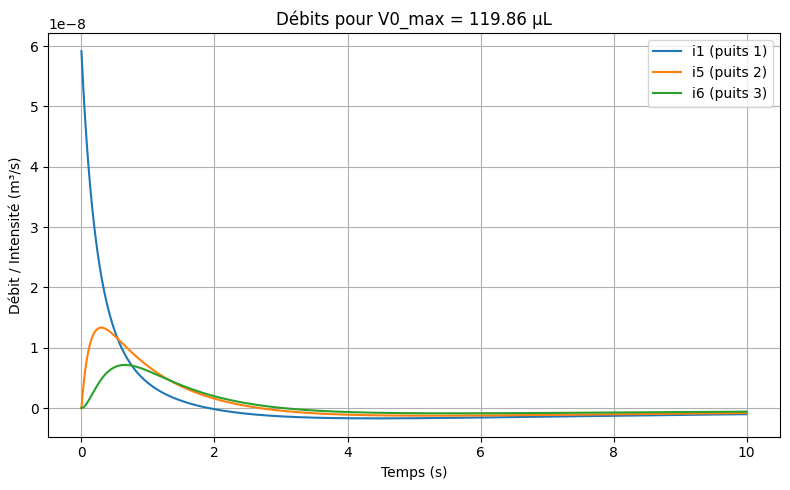

In [71]:
# ------------------------------
# Calcul du coefficient de proportionnalité
# ------------------------------
V_test = 1e-9  # 1 µL
V1_test, V5_test, V6_test, t, i1, i5, i6 = compute_volumes(L1, L2, L4, V_test)

# Chaque volume écoulé est proportionnel à V0 → V_i = k_i * V0
k1, k5, k6 = V1_test / V_test, V5_test / V_test, V6_test / V_test
V0_max = min(Vmax / k1, Vmax / k5, Vmax / k6)

# ------------------------------
# Résultats et tracé
# ------------------------------
print("\n--- PARAMÈTRES ---")
print(f"L1={L1*1e3:.2f} mm, L2={L2*1e3:.2f} mm, L4={L4*1e3:.2f} mm")
print(f"Vmax autorisé par trou = {Vmax*1e9:.3f} µL")
print(f"\nCoefficients k_i (V_i = k_i * V0) :")
print(f"Trou 1 : k1={k1:.3f},  Trou 2 : k5={k5:.3f},  Trou 3 : k6={k6:.3f}")
print(f"\n=> Volume injecté maximal V0_max = {V0_max*1e9:.3f} µL")

# Vérification : recalcul avec V0_max
V1, V5, V6, t, i1, i5, i6 = compute_volumes(L1, L2, L4, V0_max)

print("\n--- VOLUMES ÉCOULÉS POUR V0_max ---")
print(f"Trou Raman 1 : {V1*1e9:.4f} µL")
print(f"Trou Raman 2 : {V5*1e9:.4f} µL")
print(f"Trou Raman 3 : {V6*1e9:.4f} µL")

# --- Tracé des débits
plt.figure(figsize=(8,5));
plt.plot(t, i1, label="i1 (puits 1)");
plt.plot(t, i5, label="i5 (puits 2)");
plt.plot(t, i6, label="i6 (puits 3)");
plt.xlabel("Temps (s)");
plt.ylabel("Débit / Intensité (m³/s)");
plt.title(f"Débits pour V0_max = {V0_max*1e9:.2f} µL");
plt.legend();
plt.grid(True);
plt.tight_layout();
plt.show();
